In [1]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image


In [2]:
# Loading and Transforming data
transform = transforms.Compose([transforms.ToTensor(),  transforms.Normalize((0.4914, 0.4822, 0.4466), (0.247,            0.243, 0.261))])
trainTransform  = tv.transforms.Compose([tv.transforms.ToTensor(), tv.transforms.Normalize((0.4914, 0.4822, 0.4466), (0.247, 0.243, 0.261))])
trainset = tv.datasets.CIFAR10(root='./data',  train=True,download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=False, num_workers=4)
testset = tv.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

  6%|▌         | 10125312/170498071 [00:24<06:32, 408566.67it/s]


KeyboardInterrupt: 

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=5),
            nn.ReLU(True),
            nn.Conv2d(6,16,kernel_size=5),
            nn.ReLU(True))
        self.decoder = nn.Sequential(             
            nn.ConvTranspose2d(16,6,kernel_size=5),
            nn.ReLU(True),
            nn.ConvTranspose2d(6,3,kernel_size=5),
            nn.ReLU(True))
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5)
    outputs = []
    for epoch in range(num_epochs):
        for data in dataloader:
            img, _ = data
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    return outputs


Now, we can train this network.

In [ ]:
model = Autoencoder()
max_epochs = 5
outputs = train(model, num_epochs=max_epochs)

Epoch:1, Loss:0.3149
Epoch:2, Loss:0.3073
Epoch:3, Loss:0.3020
Epoch:4, Loss:0.3009
Epoch:5, Loss:0.3007


The loss goes down as we train, meaning that our reconstructed images look more and more like the actual images!

Let's look at the training progression: that is, the reconstructed images at various points of training:

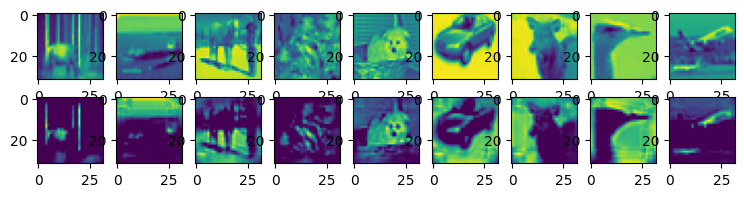

In [ ]:
import matplotlib.pyplot as plt

for k in range(0, max_epochs, 5):
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

.



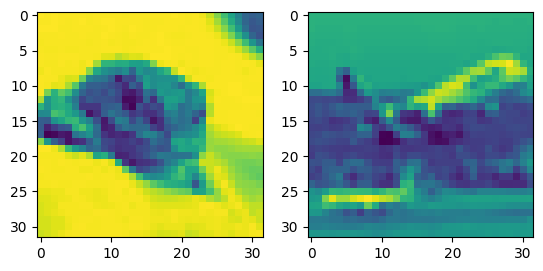

In [ ]:
imgs = outputs[max_epochs-1][1].detach().numpy()
plt.subplot(1, 2, 1)
plt.imshow(imgs[12][0])
plt.subplot(1, 2, 2)
plt.imshow(imgs[8][0])

We will then compute the low-dimensional embeddings of both images, by applying the encoder:

In [ ]:
x1 = outputs[max_epochs-1][1][12,:,:,:] # first image
x2 = outputs[max_epochs-1][1][8,:,:,:] # second image
x = torch.stack([x1,x2])     # stack them together so we only call `encoder` once
embedding = model.encoder(x)
e1 = embedding[0] # embedding of first image
e2 = embedding[1] # embedding of second image

In [ ]:
embedding_values = []
for i in range(0, 10):
    e = e1 * (i/10) + e2 * (10-i)/10
    embedding_values.append(e)
embedding_values = torch.stack(embedding_values)

recons = model.decoder(embedding_values)

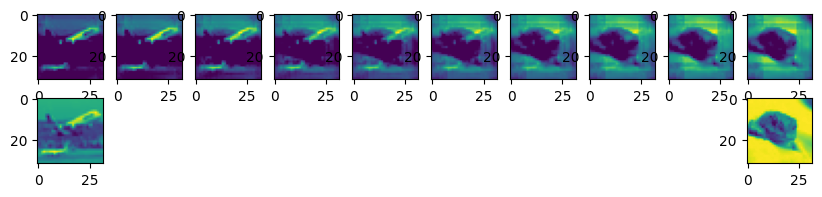

In [ ]:
plt.figure(figsize=(10, 2))
for i, recon in enumerate(recons.detach().numpy()):
    plt.subplot(2,10,i+1)
    plt.imshow(recon[0])
plt.subplot(2,10,11)
plt.imshow(imgs[8][0])
plt.subplot(2,10,20)
plt.imshow(imgs[12][0])

Notice that there is a smooth transition between the two images! The middle images are likely new, in that there are no training images that are exactly like any of the generated images.

In [ ]:
def interpolate(index1, index2):
    x1 = trainset[index1][0]
    x2 = trainset[index2][0]
    x = torch.stack([x1,x2])
    embedding = model.encoder(x)
    e1 = embedding[0] # embedding of first image
    e2 = embedding[1] # embedding of second image


    embedding_values = []
    for i in range(0, 10):
        e = e1 * (i/10) + e2 * (10-i)/10
        embedding_values.append(e)
    embedding_values = torch.stack(embedding_values)

    recons = model.decoder(embedding_values)

    plt.figure(figsize=(10, 2))
    for i, recon in enumerate(recons.detach().numpy()):
        plt.subplot(2,10,i+1)
        plt.imshow(recon[0])
    plt.subplot(2,10,11)
    plt.imshow(x2[0])
    plt.subplot(2,10,20)
    plt.imshow(x1[0])

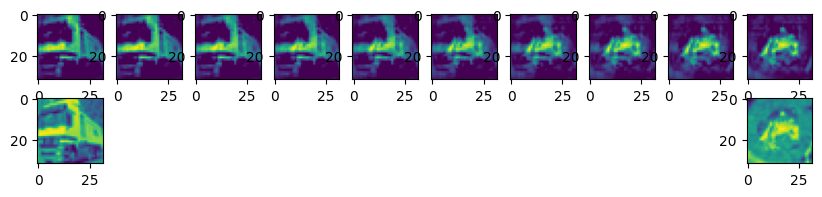

In [ ]:
interpolate(0, 1)

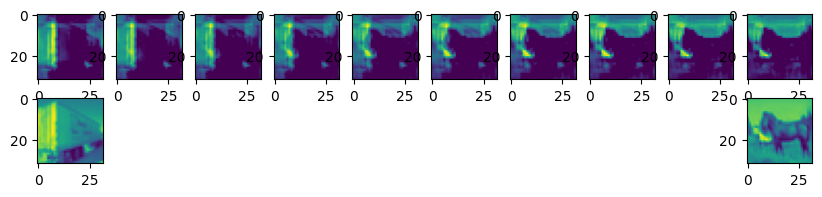

In [ ]:
interpolate(12, 15)

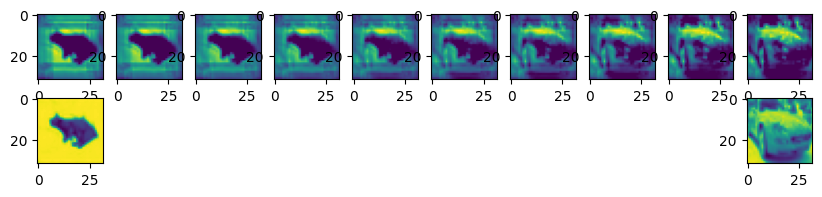

In [ ]:
interpolate(5, 21)